In [1]:
cd ..

/home/msi/projects/diplomka


In [2]:
import pandas as pd

In [3]:
!ls data/sites/

AGLT2-CSCS_LCG2      GLOW-CSCS_LCG2	Nebraska-CSCS_LCG2
BNL_ATLAS-CSCS_LCG2  INFN-T1		SARA_MATRIX-CSCS_LCG2
CA_SFU_T2-CSCS_LCG2  INFN_T1-CSCS_LCG2
FZK_LCCG2-INFN_T1    NDGF_T1-CSCS_LCG2


In [4]:
import glob

In [5]:
files = sorted(glob.glob('data/sites/INFN_T1-CSCS_LCG2/*.json'))

In [6]:
import json

In [7]:
with open(files[18689], 'r') as f:
    data = json.load(f)

In [8]:
data

{'max_rtt': 18.9,
 'src_VO': 'ATLAS',
 'created_at': '2023-01-18T17:16:50.097470799Z',
 'dest': '2001:620:808:4129::15',
 'src_site': 'INFN-T1',
 'path_complete': False,
 'MA': '2001:760:4205:254::12',
 'destination_reached': True,
 'ipv6': True,
 'dest_production': True,
 'asns': [137, 0, 137, 137, 137, 20965, 20965, 20965, 559, 559, 559],
 'n_hops': 11,
 'timestamp': 1674061240000,
 'src': '2001:760:4205:254::12',
 'dest_site': 'CSCS-LCG2',
 'dest_VO': 'ATLAS',
 'looping': False,
 'src_host': 'perfsonar-ow.cnaf.infn.it',
 'push': False,
 'route-sha1': 'ba4ceca130b0730eb9fdf490d461f136912dcf02',
 'ttls': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
 'rtts': [0.8, 0.2, 0.4, 3.4, 6.3, 6.2, 13.5, 18.9, 17.2, 15.4, 14.6],
 'dest_host': 'perfsonar02.lcg.cscs.ch',
 'hops': ['2001:760:4205:254::2',
  'fd00:0:0:150::156',
  '2001:760:ffff:110::1c',
  '2001:760:ffff:ffaa::180:51',
  '2001:760:ffff:ffaa::180:57',
  '2001:798:1e:10aa::9',
  '2001:798:cc::1d',
  '2001:798:12:10aa::2',
  '2001:620:0:c05c:

In [9]:
data.keys()

dict_keys(['max_rtt', 'src_VO', 'created_at', 'dest', 'src_site', 'path_complete', 'MA', 'destination_reached', 'ipv6', 'dest_production', 'asns', 'n_hops', 'timestamp', 'src', 'dest_site', 'dest_VO', 'looping', 'src_host', 'push', 'route-sha1', 'ttls', 'rtts', 'dest_host', 'hops', 'src_production'])

In [10]:
data['asns']

[137, 0, 137, 137, 137, 20965, 20965, 20965, 559, 559, 559]

In [11]:
from collections import defaultdict

In [12]:
import numpy as np

In [13]:
from hashlib import sha1

In [14]:
def remove_duplicates(values):
    deduped = []
    initial = values[0]
    for value in values[1:]:
        if value != initial:
            deduped.append(value)
            initial = value
    return deduped

In [15]:
def get_hash(values):
    return sha1(
            str(values).encode('utf-8')
        ).hexdigest()[-8:]

In [16]:
asn_transition_probs = defaultdict(lambda: defaultdict(lambda: 0))
asn_ip_prob = defaultdict(lambda: defaultdict(lambda: 0))

In [17]:
from traced_v2.models.poisson import PoissonModel

In [18]:
n_hops_model = PoissonModel("src", "dest") 

In [19]:
from traced.models.bernoulli_model import BernoulliModel

In [20]:
reached = BernoulliModel("src", "dest")

In [21]:
path_complete = BernoulliModel("src", "dest")

In [22]:
asn_probs = []
ip_probs = []
timestamps = []
n_hops = []

asn_hashes = []
uniq_asn_hashes = []
asn_error = []

for file in files:
    with open(file, 'r') as f:
        data = json.load(f)
    n_hops_model.log(data['timestamp'], len(data['hops']))    
    if not ('asns' in data and data['asns'] and 'hops' in data and data['hops']): 
        continue
    
    reached.log(data['timestamp'], data['destination_reached'])    
    path_complete.log(data['timestamp'], data['path_complete'])    
    
    timestamps.append(data['timestamp'])
    n_hops.append(len(data['hops']))
    current_asn = -1
    
    _asn_probs = []
    _ip_probs = []
    _mixed_probs = []
    
    for asn, ip in zip(data['asns'], data['hops']):
        _asn_probs.append(asn_transition_probs[current_asn][asn] / (1+sum(asn_transition_probs[current_asn].values())))
        asn_transition_probs[current_asn][asn] += 1
        _ip_probs.append(asn_ip_prob[asn][ip] / (1+sum(asn_ip_prob[asn].values())))
        asn_ip_prob[asn][ip] += 1
        current_asn = asn
        
    asn_probs.append(_asn_probs)
    ip_probs.append(_ip_probs)
    
    asn_hashes.append(get_hash(data['asns']))
    uniq_asn_hashes.append(get_hash(remove_duplicates(data['asns'])))
    

In [23]:
timestamps = pd.to_datetime(timestamps, unit='ms')

In [24]:
final = np.hstack([np.mean(np.array(asn_probs[i]) * np.array(ip_probs[i])).T for i in range(len(ip_probs))])

In [25]:
K = np.hstack([np.log1p(np.mean(np.array(x)))for x in ip_probs])

In [26]:
L = np.hstack([np.exp(-np.linalg.norm(np.array(x)))for x in asn_probs])

In [27]:
K

array([0.        , 0.        , 0.11415292, ..., 0.14261161, 0.13922549,
       0.13812955])

In [28]:
T = pd.DataFrame(
    {'asn_prop_t':K.flatten(), 'ip_prob': L.flatten() , 'asn_hash': asn_hashes, 'uniq_asns': uniq_asn_hashes,'final':final, 'timestamp': pd.to_datetime(timestamps, unit='ms')})

In [29]:
T['final_diff'] = T['final'].diff()

In [30]:
T['asn_prop_diff'] = T['asn_prop_t'].diff()

In [31]:
# T.plot(backend='plotly', y='asn_prop_t', x='timestamp', kind='scatter', color='asn_hash')

In [32]:
grouped = T.groupby('asn_hash')

In [33]:
models = {}

In [34]:
from traced_v2.models.normal import NormalModel

In [35]:
for i, x in grouped.groups.items():
    trace = T[T['asn_hash']==i].set_index('timestamp').sort_index()
    models[i] = NormalModel("src", "dest", one_sided=False, sigma_0=0, mu_0=0.3, sigma_factor=3, gamma=1)
    for j, val in trace[('asn_prop_t')].items():
        models[i].log(j.timestamp()*1000, np.exp(val))
        
    

In [36]:
import matplotlib.pyplot as plt



In [37]:
# for m in models.values():
#     fig = plt.figure()
#     m.plot()
#     fig.show()

In [38]:
 T[T['asn_hash']=='303fd16d'].sort_values('timestamp')


,asn_prop_t,ip_prob,asn_hash,uniq_asns,final,timestamp,final_diff,asn_prop_diff


In [39]:
import matplotlib.pyplot as plt
from math import prod

In [40]:
final = np.hstack([-np.log1p(np.mean(np.array(asn_probs[i]))).T for i in range(len(ip_probs))])

In [41]:
final2 = np.stack([np.sum(x)] for x in asn_probs)

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [42]:
np.where(final > -.5)[0]

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

In [43]:
uniqs = np.unique(uniq_asn_hashes)

In [44]:
cmap = plt.cm.viridis

In [45]:
uniqs

array(['0b90932e', '22b6d2f9', '2a97674c', '3a29975e', '44580a0d',
       '4c7cc3cc', '5349d60b', '615cc7be', '67065e0d', '7f126298',
       '90bcefe6', 'd0ed4502', 'd77392a5', 'ea30d07d', 'ebbdb9b9',
       'efe3e0c0'], dtype='<U8')

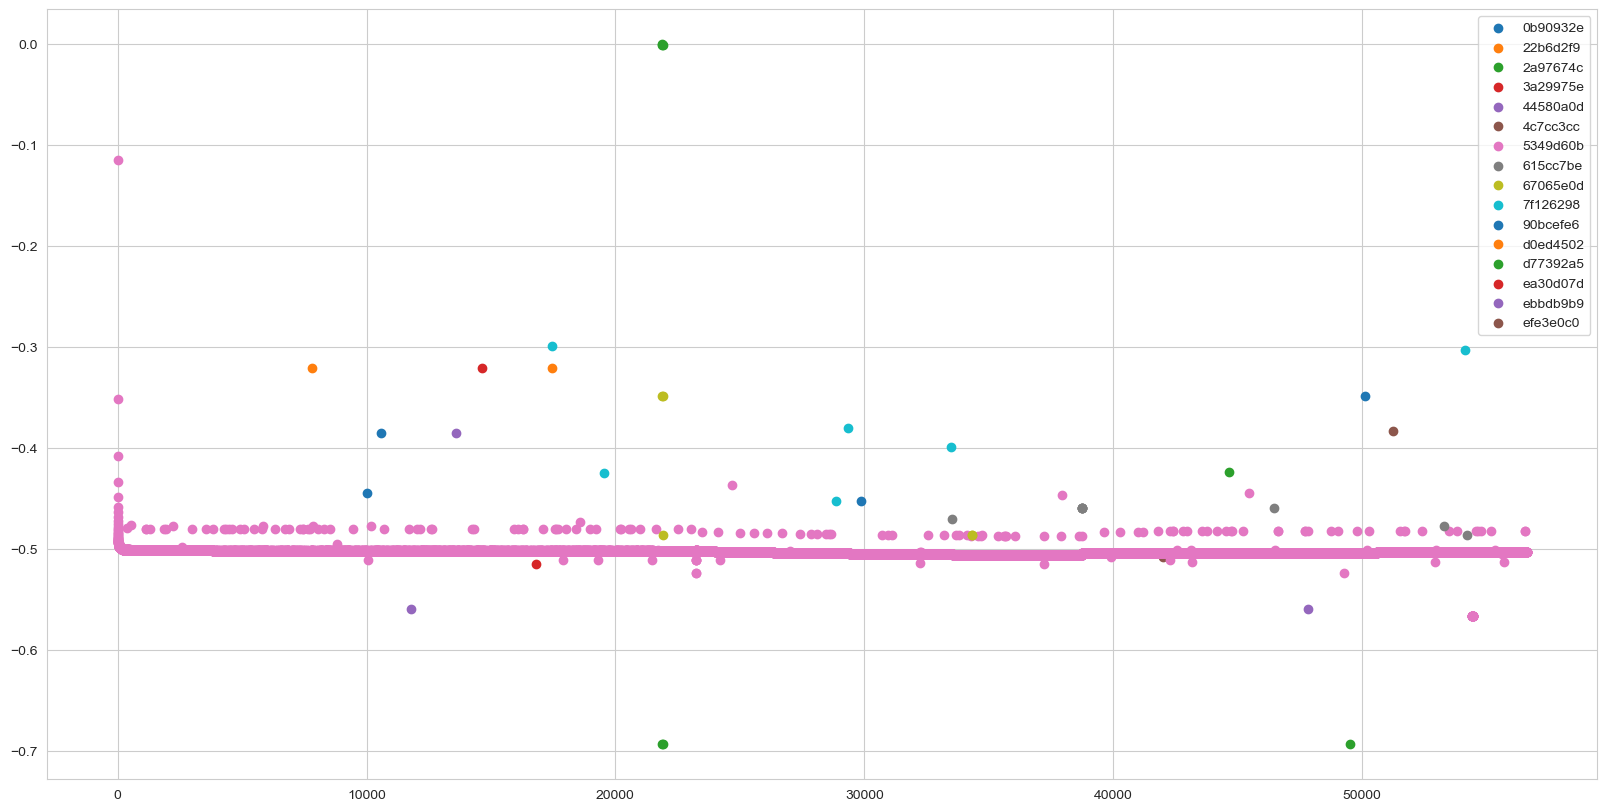

In [46]:
index = np.arange(final.shape[0])
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for i, u in enumerate(uniqs):
    sub_index = np.where(np.array(uniq_asn_hashes)==u)
    ax.scatter(index[sub_index], final[sub_index], label=u)
plt.legend()


<Axes: >

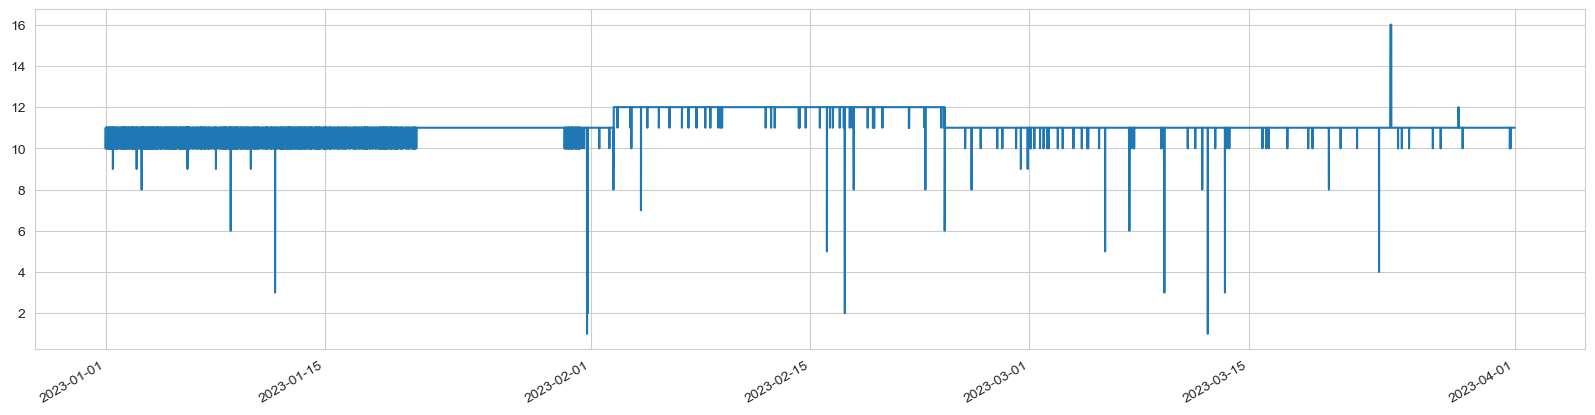

In [47]:
fig = plt.figure(figsize=(20, 5))
ax =  fig.gca()
nh = n_hops_model.to_frame()
nh['observed_values'].plot(ax=ax) 

In [48]:
nh

,observed_values,expected_values,probabilities,anomalies
2023-01-01 00:01:41,10,7.333333,0.080989,False
2023-01-01 00:01:46,11,8.250000,0.078869,False
2023-01-01 00:06:00,11,8.800000,0.092547,False
2023-01-01 00:06:08,11,9.166667,0.100493,False
2023-01-01 00:07:17,11,9.428571,0.105432,False
...,...,...,...,...
2023-03-31 23:16:46,11,11.250406,0.119043,False
2023-03-31 23:26:08,11,11.250402,0.119043,False
2023-03-31 23:29:47,11,11.250397,0.119043,False
2023-03-31 23:37:37,11,11.250393,0.119043,False


(-0.05, 1.0)

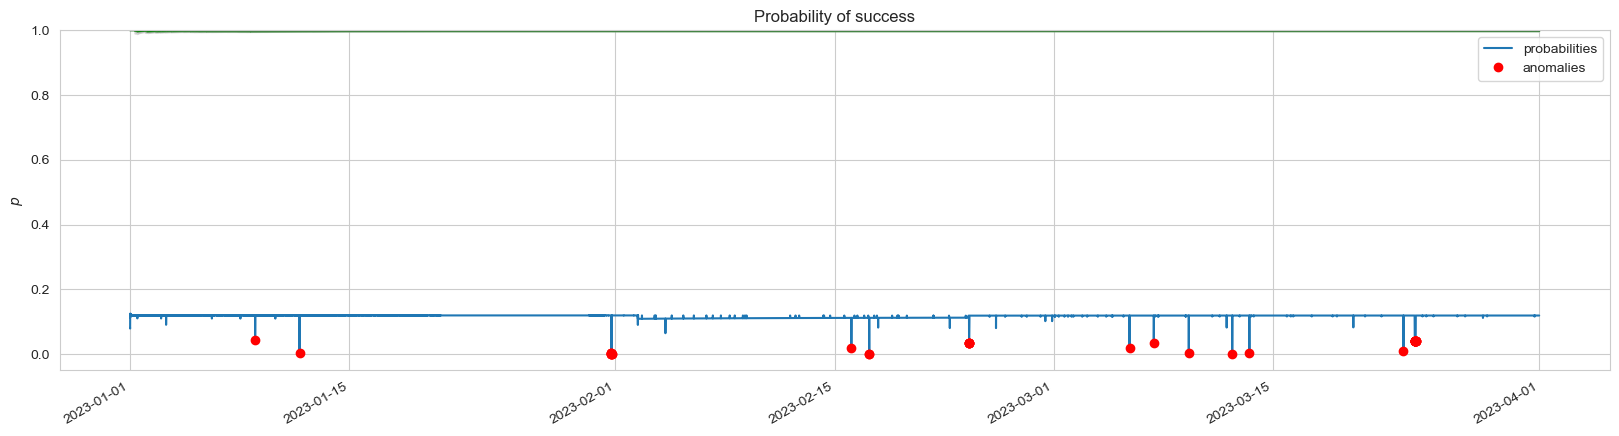

In [49]:
fig = plt.figure(figsize=(20, 5))
ax =  fig.gca()
n_hops_model.plot(ax=ax)
# path_complete.plot(ax=ax)
reached.plot(ax=ax)
ax.set_ylim(-0.05, 1 )


In [50]:
for i, x in {'asn': asn_hashes, 'uniq_asn': uniq_asn_hashes, 'n_hops_prob': n_hops_model.probs[1:], 'dest_reach_prob': reached.success_probs[1:], 'path_complete_prob': path_complete.success_probs[1:], 'final':final[1:], 'timestamp': timestamps}.items():
    print(i, len(x))

asn 56619
uniq_asn 56619
n_hops_prob 56619
dest_reach_prob 56619
path_complete_prob 56619
final 56618
timestamp 56619


In [51]:
df = pd.DataFrame({'asn': asn_hashes, 'uniq_asn': uniq_asn_hashes, 'n_hops_prob': n_hops_model.probs[2:], 'dest_reach_prob': reached.success_probs[1:], 'path_complete_prob': path_complete.success_probs[1:], 'final':final, 'timestamp': timestamps})

ValueError: All arrays must be of the same length

In [ ]:
df['asn'] = df['asn'].astype('category')
df['uniq_asn'] = df['uniq_asn'].astype('category')
# df.set_index('timestamp', inplace=True)

In [ ]:
# df.plot(backend='matplotlib', y=['n_hops_prob', 'dest_reach_prob', 'path_complete_prob'], x='timestamp', kind='scatter', color='asn')
fig = plt.figure(figsize=(20,5))
ax = plt.gca()
df.plot(backend='matplotlib', y= 'dest_reach_prob', x='timestamp', kind='scatter', c='uniq_asn', cmap='tab20_r', ax=ax)

In [ ]:
# df.plot(backend='matplotlib', y=['n_hops_prob', 'dest_reach_prob', 'path_complete_prob'], x='timestamp', kind='scatter', color='asn')
fig = plt.figure(figsize=(20,5))
ax = plt.gca()
df.plot(backend='matplotlib', y= 'final', x='timestamp', kind='scatter', c='uniq_asn', cmap='tab20_r', ax=ax)

In [ ]:
# df.plot(backend='matplotlib', y=['n_hops_prob', 'dest_reach_prob', 'path_complete_prob'], x='timestamp', kind='scatter', color='asn')
fig = plt.figure(figsize=(20,5))
ax = plt.gca()
df.plot(backend='matplotlib', y= 'path_complete_prob', x='timestamp', kind='scatter', c='uniq_asn', cmap='tab20_r', ax=ax)

In [ ]:
# df.plot(backend='matplotlib', y=['n_hops_prob', 'dest_reach_prob', 'path_complete_prob'], x='timestamp', kind='scatter', color='asn')
fig = plt.figure(figsize=(20,5))
ax = plt.gca()
df.plot(backend='matplotlib', y= 'final', x='n_hops_prob', kind='scatter', c='uniq_asn', cmap='tab20_r', ax=ax)

In [ ]:
from traced_v2.models.multinomial import MultinomialModel

In [ ]:
mm = MultinomialModel("src", "dest")


In [ ]:
df

In [ ]:

mm = MultinomialModel("src", "dest")

for i, x in df.set_index('timestamp')['uniq_asn'].items():
    mm.log(i.timestamp()*1000, x)    

In [ ]:
mm.category_probs

In [ ]:
df['uniq_asn_prob'] = df['uniq_asn'].apply(mm.category_probs.__getitem__)

In [ ]:
df['uniq_asn_prob']

In [ ]:

mm = MultinomialModel("src", "dest")

for i, x in df.set_index('timestamp')['asn'].items():
    mm.log(i.timestamp()*1000, x)    

In [ ]:
df['asn_prob'] = df['asn'].apply(mm.category_probs.__getitem__)

In [ ]:
df['asn_prob']

In [ ]:
for i, x in df.sort_values(by='asn_prob', ascending=False).groupby('asn'):
    if x.shape[0] < 3:
        continue
    print(i, f"{mm.category_probs[i]*100: .3f}%")
    display(x.select_dtypes(include=[int, float]).corr(method='pearson'))
    fig = plt.figure()
    x.plot(ax=plt.gca(), kind='scatter', x='timestamp', y='n_hops_prob', label='n_hops_prob', c='r')
    x.plot(ax=plt.gca(), kind='scatter', x='timestamp', y='dest_reach_prob', label='dest_reach_prob', c='g')
    x.plot(ax=plt.gca(), kind='scatter', x='timestamp', y='path_complete_prob', label='path_complete_prob', c='b')
    plt.show()

In [ ]:
df.select_dtypes(exclude=['object'], include=[float]).corr(method='pearson')

In [ ]:
plt.plot(final)

In [ ]:
final.shape[0]

In [ ]:
from traced_v2.models.normal import NormalModel

In [ ]:
model = NormalModel("src", "dest", one_sided=True, sigma_0=1.5, mu_0=0, sigma_factor=4, gamma=0.5)

In [ ]:
for i, val in enumerate(final):
    model.log(i, val)

In [ ]:
fig = plt.figure(figsize=(20, 10))
model.plot()

In [ ]:
final = list(map(np.log1p, map(np.mean, final)))

In [ ]:
from scipy.stats import hmean

In [ ]:
final

In [ ]:
y= np.array(np.log1p(list(map(prod, ip_probs))))


In [ ]:
x = np.array(np.log1p(list(map(prod, asn_probs))))

In [ ]:
import pandas as pd

In [ ]:
tmp = pd.DataFrame(
    {'asn_prob': x, 'ip_prob': y, 'asn_hash': asn_hashes,  'length': n_hops, 'timestamp': timestamps, 'unique_asns': uniq_asn_hashes, 'final': final})


In [ ]:
tmp['asn_color'] = tmp['asn_hash'].astype('category')#.cat.codes

In [ ]:
tmp['unique_asns'] = tmp['unique_asns'].astype('category')#.cat.codes

In [ ]:
tmp['unique_asns_cat'] = tmp['unique_asns'].astype('category').cat.codes


In [ ]:
import seaborn as sns
sns.set_style("whitegrid")

In [ ]:
import plotly.graph_objects as go

In [ ]:
from traced_v2.models.normal import NormalModel

In [ ]:
model = NormalModel("src", "dest", one_sided=False, sigma_0=0.001, mu_0=0.2, sigma_factor=3, beta_0=0.05)

In [ ]:
for i, row in tmp.set_index('timestamp')['final'].items():
    model.log(i.timestamp()*1000, row)

In [ ]:
model.plot()

In [ ]:
tmp['asn_prob_log'] = np.log1p(tmp['asn_prob'])

In [ ]:
tmp.plot(backend='plotly', y='asn_prob_log', x='timestamp', kind='scatter', color='asn_hash')

In [ ]:
import importlib

In [ ]:
from traced.models import MultinomialModel


In [ ]:
import traced

In [ ]:
traced.models = importlib.reload(traced.models)

In [ ]:
traced.models.multinomial_model = importlib.reload(traced.models.multinomial_model)

In [ ]:
from traced.models.multinomial_model import MultinomialModel

In [ ]:
mm = MultinomialModel("src", "dest")

In [ ]:
probs=[]
for i, x in tmp.set_index('timestamp')['asn_hash'].items():
   _,_, p =  mm.log(i, x)
   probs.append(p)

In [ ]:
tmp['asn_observed_prob'] = -np.log1p((probs))

In [ ]:
plt.plot(tmp['asn_observed_prob'])

In [ ]:
tmp['prob_asn_prob'] = tmp.apply(lambda x: np.log1p(-x['asn_prob'] * x['asn_observed_prob'] ), axis=1)#.plot(kind='scatter')

In [ ]:
tmp.plot(backend='plotly', y='prob_asn_prob', x='timestamp', kind='scatter', color='asn_hash')

In [ ]:
nn = NormalModel("src", "dest", one_sided=True, sigma_0=1, mu_0=-0.2, sigma_factor=3, beta_0=.01, alpha_0=1)

In [ ]:
for i, x in tmp.set_index('timestamp')['prob_asn_prob'].items():
    nn.log(i.timestamp()*1000, x)

In [ ]:
nn.plot()